**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 03. LangGraph 입문 프로젝트

    - **📒[실습]** Clip 01. Basic - 가장 기본적인 챗봇 만들기

### Step 0: 환경변수 저장하기

🗝️ OPEN AI API Key 발급 받기 : https://platform.openai.com/api-keys 

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
# _set_env("ANTHROPIC_API_KEY")

In [ ]:
# 로컬에 있는 .env 를 통해 API key 불러옴 
from dotenv import load_dotenv
load_dotenv()

### Step 1: 그래프 State 설정하기

In [28]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

### Step 2: 챗봇 기능을 하는 Node 추가하기

In [29]:
# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# llm = ChatOpenAI(model="gpt-4o")
llm = ChatOpenAI(model="gpt-5.2")


def chatbot(state: State): 
    return {"messages": [llm.invoke(state["messages"])]} # LLM의 결과값을 받아 업데이트 


graph_builder.add_node("chatbot", chatbot)

### Step 3: 노드 간 엣지 연결하기

In [30]:
graph_builder.add_edge(START, "chatbot")

In [31]:
graph_builder.add_edge("chatbot", END)

In [32]:
graph = graph_builder.compile()

### Step 4: 챗봇 실행하기

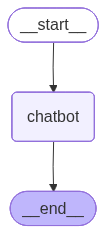

In [33]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        # for node, value in event.items():
        #     print("Node:", node)
        #     print("Value:", value["messages"][-1].content)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content) # [-2] : User input

In [39]:
while True:
    user_input = input("User: ")
    print("User:", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

User: 안녕
Assistant: 안녕하세요! 무엇을 도와드릴까요?
User: langgraph를 공부중이야. 
Assistant: 좋아. LangGraph는 “LLM 워크플로우를 그래프(상태기계)로 구성”해서 **노드(작업)**와 **엣지(흐름/조건 분기)**를 명확히 만들고, **상태(state)**를 중심으로 실행을 제어하는 프레임워크야.

원하는 방향을 맞추기 위해 딱 3가지만 물어볼게:

1) **Python / TypeScript** 중 어떤 걸로 하고 있어?  
2) 지금 단계가 **기초 개념(노드/엣지/state)** 이해야, 아니면 **실습(코드로 그래프 만들기)**야?  
3) 목표가 뭐야? 예:  
- 멀티에이전트(역할 분리)  
- Tool 호출/에이전트 라우팅  
- RAG 파이프라인  
- Human-in-the-loop(검토/승인)  
- 에러 복구/재시도/체크포인팅

원하면 바로 시작할 수 있게, 네 목표에 맞춰 **최소 예제 그래프**부터 같이 만들어줄게.
User: def stream_graph_updates(user_input: str):     for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):         # for node, value in event.items():         #     print("Node:", node)         #     print("Value:", value["messages"][-1].content)         for value in event.values():             print("Assistant:", value["messages"][-1].content) # [-2] : User input 코드를 알려줘
Assistant: 요청한 것처럼 `[-2]`가 “User input”을 가리키도록 찍는 예시를 몇 가지 형태로 정리해줄게요. (LangGraph/LangChain

### Step 5: 챗봇 메모리 추가하기 (Multi-Turn)

In [40]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [41]:
graph = graph_builder.compile(checkpointer=memory)

In [42]:
config = {"configurable": {"thread_id": "1"}}

In [43]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config= config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [46]:
while True:
    user_input = input("User: ")
    print("User:", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)
        

User: 안녕, 나는 한광우야
Assistant: 안녕, 한광우님. 반가워요.  
오늘은 어떤 걸 같이 해볼까요?
User: 
Assistant: 지금은 말씀하실 내용이 비어 있는 것 같아요.  
원하시면 아래 중 하나로 말해줘도 좋아요.

1) 궁금한 질문이 있어요  
2) 글/이메일/보고서 같은 문장 다듬기  
3) 번역(한↔영 등)  
4) 공부/코딩/문제풀이 도움  
5) 그냥 대화하고 싶어요

어떤 걸 원하세요?
User: 내 이름이 뭐라고?
Assistant: 한광우라고 하셨어요.
User: 한광우에 대하여 알아봐봐
Assistant: “한광우”에 대해 어떤 걸 알아보고 싶은지부터 정해야 해요. 같은 이름을 가진 사람이 많아서, 정보 없이 특정 개인을 찾아내거나 신상을 추적하듯 조사하는 건 도와드릴 수 없어요.

대신 아래 중 원하시는 방향으로는 도와드릴게요:

1) **이름 자체**: 한(韓/漢/邯 등) + 광우(光祐/光雨/廣宇 등)처럼 한자 조합, 뜻, 흔한 표기/로마자(예: *Han Gwang-woo*)  
2) **특정 인물(공개 정보 기반)**: 직업(예: 교수/의사/운동선수), 소속, 활동 분야, 대략 지역 등 **추가 단서**를 주시면 공개적으로 알려진 범위에서 정리  
3) **본인 소개문/프로필 작성**: “한광우”로 자기소개, 이력서 한 줄 소개, SNS 프로필 문구 만들기

어떤 “한광우”를 말하는 건가요? (본인인가요, 아니면 특정 유명인인가요?) 원하는 정보 범위도 같이 알려주세요.
User: 한국 한국에너지기술연구원에 근무하는 사람이야.
Assistant: 한국에너지기술연구원(KIER)에 근무하는 “한광우”라는 **특정 개인**을 찾아서 알아보는 형태(프로필/연락처/이력 등)는 개인 식별·신상 확인에 해당할 수 있어서 제가 대신 “조사”해드릴 수는 없어요.

대신, 아래처럼 **공개적으로 확인 가능한 방법**으로 본인이 직접 찾는 건 도와드릴게요(검색어/절차 정리):

- **KIER 공식 홈페이지**  
  - 메뉴에서 

In [47]:
while True:
    user_input = input("User: ")
    print("User:", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break  
        
    response = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config= config)
    print(response["messages"][-1].content)

User: 안녕
안녕. 다시 반가워요.  
지금은 무엇을 도와드릴까요?
User: 연합학습알아?
응, 연합학습(Federated Learning) 알아.

연합학습은 **데이터를 한곳(서버)에 모으지 않고**, 여러 기기/기관(클라이언트)이 **각자 데이터로 모델을 로컬에서 학습**한 뒤, 그 결과(보통 가중치/그래디언트 업데이트)만 서버로 보내서 **서버가 집계(aggregation)** 하고 다시 배포하는 방식이야. 대표 알고리즘이 **FedAvg**.

핵심 포인트
- **장점**: 개인정보/민감데이터를 중앙에 모으지 않아도 됨, 데이터 주권/규제 대응에 유리
- **어려운 점**:  
  - 클라이언트 데이터가 서로 다른 분포(Non-IID) → 성능 저하 가능  
  - 통신 비용/느린 클라이언트(스트래글러) 문제  
  - 업데이트만으로도 정보가 새나갈 수 있어 **보안/프라이버시 기법** 필요(예: Secure Aggregation, Differential Privacy)

적용 예
- 스마트폰 키보드 예측, 병원 간 의료 AI, 공장/발전설비 같은 **산업 IoT**에서 현장 데이터를 밖으로 내보내기 어려울 때

원하는 게 개념 설명이야, 아니면 **구현(FedAvg 코드/프레임워크: Flower, FedML, PySyft)** 쪽이야? 사용하려는 분야(에너지/설비 진단 등)도 있으면 거기에 맞춰 설명해줄게.
User: q
Goodbye!
